In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Questão 1

### Dataset


In [241]:
# Definindo os padrões de entrada (vértices do cubo)
entradas = np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1]
]).astype(float)

# Vetores de resposta associados a cada padrão de entrada
respostas = np.array([
    [1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 1, -1, -1, -1, -1],
    [-1, -1, -1, -1, 1, -1, -1, -1],
    [-1, -1, -1, -1, -1, 1, -1, -1],
    [-1, -1, -1, -1, -1, -1, 1, -1],
    [-1, -1, -1, -1, -1, -1, -1, 1]
]).astype(float)

In [242]:
# Função para adicionar ruído aos padrões de entrada
def adicionar_ruido(entradas, raio_ruido):
    # Cria uma cópia das entradas para não alterar o array original
    entradas_ruidosas = np.copy(entradas)
    # Adiciona ruído aleatório dentro do raio especificado
    ruido = np.random.uniform(-raio_ruido, raio_ruido, entradas.shape)
    entradas_ruidosas += ruido
    return entradas_ruidosas

# Definindo o raio máximo do ruído
raio_ruido = 0.1

# Criando o conjunto de validação com ruído
conjunto_validacao = adicionar_ruido(entradas, raio_ruido)
conjunto_validacao.shape

(8, 3)

In [243]:
X = entradas.T
Y = respostas.reshape((8, len(respostas)))

print ('The shape of X: ' + str(X.shape))
print ('The shape of Y: ' + str(Y.shape))
print ('I have m = %d training examples!' % (X.shape[1]))


The shape of X: (3, 8)
The shape of Y: (8, 8)
I have m = 8 training examples!


# Perceptron de Rosenblatt

In [244]:
def layer_sizes(X, Y):
    n_x = X.shape[0]  # Size of input layer
    n_y = Y.shape[0]  # Size of output layer
    return (n_x, n_y)

In [245]:
(n_x, n_y) = layer_sizes(X, Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 3
The size of the output layer is: n_y = 8


Temos 8 exemplos de treinamento, com 3 atributos cada.

In [246]:
def initialize_parameters(n_x, n_y):
    W = np.random.randn(n_y, n_x) * 0.01  # Small random weights
    b = np.zeros((n_y, 1))  # Bias initialized to zero
    return {"W": W, "b": b}

In [247]:
def forward_propagation(X, parameters):
    W = parameters['W']
    b = parameters['b']
    Z = np.dot(W, X) + b
    A = np.where(Z > 0, 1, -1)  # Activation using sign function
    return A

In [248]:
def update_parameters(parameters, X, Y, learning_rate):
    m = X.shape[1]  # Número de exemplos de treinamento
    W = parameters['W']
    b = parameters['b']
    for i in range(m):  # Iterar sobre cada exemplo de treinamento
        xi = X[:, [i]]  # Pegar a coluna i de X
        yi = Y[:, [i]]  # Pegar a coluna i de Y
        A = forward_propagation(xi, parameters)  # Previsão para o exemplo xi
        for j in range(Y.shape[0]):  # Iterar sobre cada saída
            if yi[j, 0] != A[j, 0]:  # Se a previsão estiver incorreta
                # Atualizar W e b para cada saída j
                W[j, :] = W[j, :] + learning_rate * yi[j, 0] * xi.T
                b[j, 0] = b[j, 0] + learning_rate * yi[j, 0]
    parameters['W'] = W
    parameters['b'] = b
    return parameters


In [249]:
def nn_model(X, Y, num_iterations=100, learning_rate=0.001):
    n_x, n_y = layer_sizes(X, Y)
    parameters = initialize_parameters(n_x, n_y)
    for i in range(num_iterations):
        parameters = update_parameters(parameters, X, Y, learning_rate)
    return parameters

In [250]:
parameters = nn_model(X, Y)


In [251]:
def predict(parameters, X):
    W = parameters['W']
    b = parameters['b']
    Z = np.dot(W, X) + b
    A = np.where(Z > 0, 1, -1)  # Aplica a função sinal
    
    predictions = A
    return predictions

# Realizando previsões com o modelo treinado
predictions = predict(parameters,conjunto_validacao.T)

# Agora, faça a iteração e imprima os resultados
for i in range(len(predictions)):
    # Assegure-se de que estamos comparando valores escalares
    acertou = "✅ Acertou" if np.array_equal(predictions[i], respostas[i])  else "❌ Errou"
    print(f"Entrada: {conjunto_validacao[i]} | Saída Prevista: {predictions[i]} | Esperado: {respostas[i]} | {acertou}")


Entrada: [-0.00408358  0.0168399   0.0473645 ] | Saída Prevista: [ 1 -1 -1 -1 -1 -1 -1 -1] | Esperado: [ 1. -1. -1. -1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [0.01154845 0.01730709 1.01289171] | Saída Prevista: [-1  1 -1 -1 -1 -1 -1 -1] | Esperado: [-1.  1. -1. -1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [-0.02424547  0.96748937  0.07992948] | Saída Prevista: [-1 -1  1 -1 -1 -1 -1 -1] | Esperado: [-1. -1.  1. -1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [0.02151104 0.94887063 0.99964954] | Saída Prevista: [-1 -1 -1  1 -1 -1 -1 -1] | Esperado: [-1. -1. -1.  1. -1. -1. -1. -1.] | ✅ Acertou
Entrada: [ 0.9660697   0.08673836 -0.09849313] | Saída Prevista: [-1 -1 -1 -1  1 -1 -1 -1] | Esperado: [-1. -1. -1. -1.  1. -1. -1. -1.] | ✅ Acertou
Entrada: [ 0.94506656 -0.02692864  0.99756196] | Saída Prevista: [-1 -1 -1 -1 -1  1 -1 -1] | Esperado: [-1. -1. -1. -1. -1.  1. -1. -1.] | ✅ Acertou
Entrada: [1.0701635  0.91757752 0.06117298] | Saída Prevista: [-1 -1 -1 -1 -1 -1  1 -1] | Esperado: [-1. -1. -1.

# Questão 2

### Perceptron MLP

In [220]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
    
        parameters['W' + str(l)] =  np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):

    Z = np.dot(W,A) + b
    cache = (A, W, b)
    
    return Z, cache

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    elif activation == "linear":  # Função de ativação linear para a camada de saída no caso de regressão
        A = Z
        activation_cache = Z
    
    cache = (linear_cache, activation_cache)
    
    return A, cache


def L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid'):
    caches = []
    A = X
    L = len(parameters) // 2                  # número de camadas na rede neural
    
    # Implementa [LINEAR -> ACTIVATION]*(L-1).
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation=hidden_activation)
        caches.append(cache)
    
    # Implementa LINEAR -> ACTIVATION na última camada.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation=output_activation)
    caches.append(cache)
          
    return AL, caches


def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * np.sum(np.square(AL - Y)) # Custo quadrático médio (usado para regressão)
    cost = np.squeeze(cost)  # Garante que a saída seja um escalar
    return cost


def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1] # número de exemplos

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "linear":
        dZ = dA
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches, hidden_activation='relu', output_activation='sigmoid', problema='regressao'):
    grads = {}
    L = len(caches)  # número de camadas
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # após esta linha, Y tem o mesmo formato que AL
    

    if problema == 'classificacao':   
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # Derivada da função de custo entropia cruzada binária
    elif problema == 'regressao':
        dAL = 2 * (AL - Y) / m # derivada do erro quadrático médio
    
    # Camada L (saída) gradientes.
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation=output_activation)
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop de l= L-2 até l=0
    for l in reversed(range(L-1)):
        # Camadas ocultas
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation=hidden_activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

import copy

def update_parameters(params, grads, learning_rate = 0.001):
   
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters



a) a função lógica XOR


In [221]:
# Definindo todas as possíveis entradas para a função XOR
x_samples = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# As saídas correspondentes para a função XOR
y_samples = np.array([0, 1, 1, 0])

# Usaremos todas as entradas para treinamento em um problema tão simples
x_train_a = x_samples
y_train_a = y_samples

# Não há necessidade de um conjunto de validação separado neste caso,
# mas se quisermos, podemos simplesmente reutilizar o conjunto de treinamento
# ou selecionar alguns dos pares de entrada para validação.
x_val_a = x_samples
y_val_a = y_samples


In [222]:
x_train_a.shape

(4, 2)

In [223]:
x_train_a.T.shape

(2, 4)

x_train_a tem 2 atributos e 4 exemplos de treinamento.

Para a função XOR, é preferível usar funções de ativação não-lineares como a função sigmoid ou ReLU em todas as camadas ocultas. A função de ativação na camada de saída depende do tipo de problema que você está tentando resolver. No caso da função XOR, como é um problema de classificação binária, você geralmente usaria a função sigmoid na camada de saída para obter uma probabilidade como saída, que você pode então arredondar para obter uma previsão de classe binária (0 ou 1).

In [271]:
# Definindo a arquitetura da rede
layers_dims_a = [x_train_a.T.shape[0], 5, 1]  # 2 neurônios na camada de entrada, 5 na camada oculta e 1 na camada de saída

# Inicializando os parâmetros
parameters_a = initialize_parameters_deep(layers_dims_a)

# Listas para armazenar custos
costs_train_a = []
costs_val_a = []

# Número de iterações de treinamento
num_iterations = 20000

# Taxa de aprendizado
learning_rate = 0.01

# Treinamento da rede
for i in range(num_iterations):
     # Propagação para frente (treinamento)
    AL_a, caches_a = L_model_forward(x_train_a.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
    
    # Cálculo do custo (treinamento)
    cost_train_a = compute_cost(AL_a, y_train_a.reshape(1, -1))
    costs_train_a.append(cost_train_a)
    
    # Propagação para trás
    grads_a = L_model_backward(AL_a, y_train_a.reshape(1, -1), caches_a, hidden_activation='relu', output_activation='sigmoid', problema='classificacao')
    
    # Atualização dos parâmetros
    parameters_a = update_parameters(parameters_a, grads_a, learning_rate)
    
    # Propagação para frente (validação)
    AL_a_val, _ = L_model_forward(x_val_a.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
    
    # Cálculo do custo (validação)
    cost_val_a = compute_cost(AL_a_val, y_val_a.reshape(1, -1))
    costs_val_a.append(cost_val_a)
    
    # Imprimir o custo a cada 1000 iterações
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train_a:.4f} - Custo de Validação: {cost_val_a:.4f}")


Iteração 0 - Custo de Treinamento: 0.2500 - Custo de Validação: 0.2500
Iteração 1000 - Custo de Treinamento: 0.2500 - Custo de Validação: 0.2500
Iteração 2000 - Custo de Treinamento: 0.2498 - Custo de Validação: 0.2498
Iteração 3000 - Custo de Treinamento: 0.2490 - Custo de Validação: 0.2490
Iteração 4000 - Custo de Treinamento: 0.2448 - Custo de Validação: 0.2448
Iteração 5000 - Custo de Treinamento: 0.2261 - Custo de Validação: 0.2260
Iteração 6000 - Custo de Treinamento: 0.1818 - Custo de Validação: 0.1818
Iteração 7000 - Custo de Treinamento: 0.1466 - Custo de Validação: 0.1466
Iteração 8000 - Custo de Treinamento: 0.1323 - Custo de Validação: 0.1322
Iteração 9000 - Custo de Treinamento: 0.1276 - Custo de Validação: 0.1276
Iteração 10000 - Custo de Treinamento: 0.1261 - Custo de Validação: 0.1261
Iteração 11000 - Custo de Treinamento: 0.1255 - Custo de Validação: 0.1255
Iteração 12000 - Custo de Treinamento: 0.1253 - Custo de Validação: 0.1253
Iteração 13000 - Custo de Treinamento:

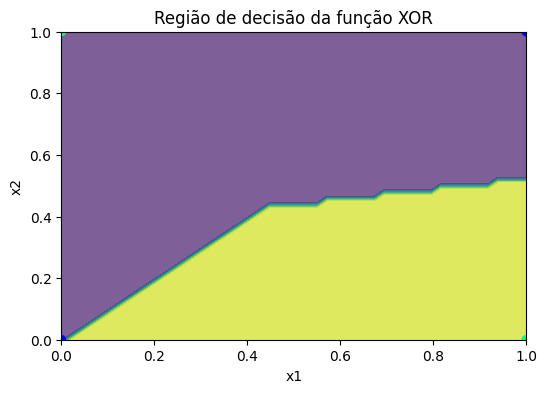

In [272]:
# Criar uma grade de pontos no intervalo de 0 a 1 (valores booleanos para XOR)
grid_x0, grid_x1 = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
grid = np.c_[grid_x0.ravel(), grid_x1.ravel()]

# Previsões para cada ponto na grade
AL_grid, _ = L_model_forward(grid.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
predictions_grid = (AL_grid > 0.5).astype(int)

# Visualizar a região de decisão
plt.figure(figsize=(6, 4))  # Aumentar o tamanho da figura
plt.contourf(grid_x0, grid_x1, predictions_grid.reshape(grid_x0.shape), alpha=0.7)
plt.scatter(x_train_a[:, 0], x_train_a[:, 1], c=y_train_a, cmap=plt.cm.winter)
plt.title("Região de decisão da função XOR")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(0, 1)  # Definir limites do eixo x
plt.ylim(0, 1)  # Definir limites do eixo y
plt.show()


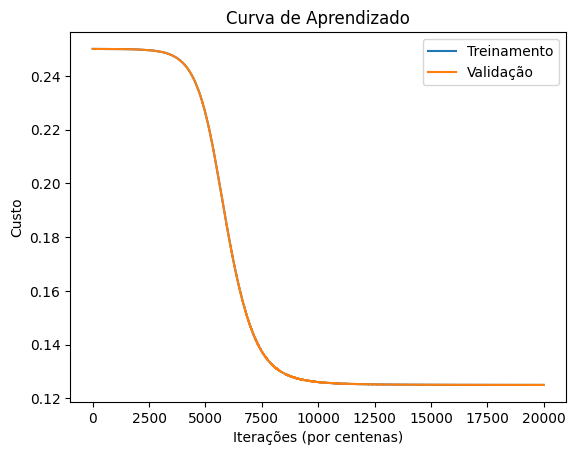

In [226]:
plt.plot(costs_train_a, label='Treinamento')
plt.plot(costs_val_a, label='Validação')
plt.ylabel('Custo')
plt.xlabel('Iterações (por centenas)')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()

b) f(x) = log10(x), onde 1 ≤ x ≤ 10


In [227]:
# Definindo a função b
def function_b(x):
    return np.log10(x)

# Gerar amostras para x (100 amostras uniformemente espaçadas entre 1 e 10)
x_samples_b = np.linspace(1, 10, 100)
y_samples_b = function_b(x_samples_b) 

# Dividindo as amostras em conjuntos de treinamento (70%) e validação (30%)
indices_b = np.random.permutation(len(x_samples_b))
train_indices_b = indices_b[:int(0.7*len(x_samples_b))]
val_indices_b = indices_b[int(0.7*len(x_samples_b)):]

# reshape pra prevenir rank 1 array, e fazer a transposição para que cada amostra seja uma coluna
x_train_b = x_samples_b[train_indices_b].reshape(1, -1)
y_train_b = y_samples_b[train_indices_b].reshape(1, -1)
x_val_b = x_samples_b[val_indices_b].reshape(1, -1)
y_val_b = y_samples_b[val_indices_b].reshape(1, -1)



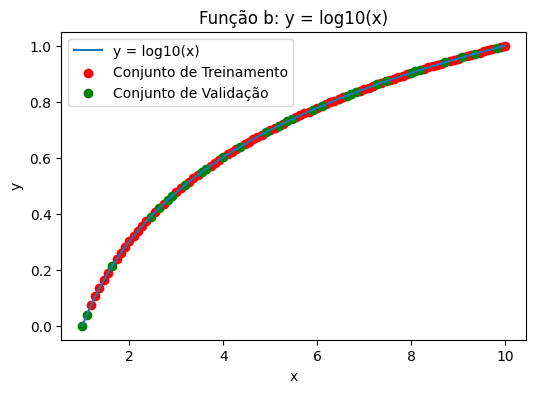

In [228]:
# plotar a função b
plt.figure(figsize=(6, 4))
plt.plot(x_samples_b, y_samples_b, label='y = log10(x)')
plt.scatter(x_train_b, y_train_b, color='r', label='Conjunto de Treinamento')
plt.scatter(x_val_b, y_val_b, color='g', label='Conjunto de Validação')
plt.title('Função b: y = log10(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [229]:
x_train_b

array([[ 2.54545455,  1.72727273,  4.18181818,  9.27272727,  1.45454545,
         2.36363636,  8.45454545,  4.81818182,  5.27272727,  5.63636364,
         5.81818182,  8.36363636,  1.54545455,  7.        ,  2.27272727,
         4.72727273,  5.09090909,  3.27272727,  3.        ,  3.09090909,
         6.90909091,  1.27272727,  7.81818182,  7.09090909,  9.54545455,
         7.90909091,  4.45454545,  4.09090909,  2.72727273,  7.63636364,
         3.81818182,  9.45454545,  1.36363636,  2.09090909,  7.18181818,
         6.27272727,  9.        ,  2.        ,  9.72727273,  6.45454545,
         1.81818182, 10.        ,  9.90909091,  4.54545455,  6.36363636,
         8.81818182,  3.45454545,  8.54545455,  6.18181818,  1.90909091,
         9.63636364,  5.        ,  4.63636364,  3.36363636,  4.27272727,
         8.63636364,  1.18181818,  5.54545455,  8.90909091,  5.72727273,
         7.54545455,  6.54545455,  9.18181818,  3.72727273,  7.72727273,
         2.18181818,  6.        ,  8.27272727,  7.3

In [230]:
y_train_b

array([[0.40576535, 0.23736092, 0.62136515, 0.96720749, 0.1627273 ,
        0.37358066, 0.92709026, 0.68288318, 0.72203531, 0.750999  ,
        0.76478729, 0.92239514, 0.18905624, 0.84509804, 0.35654732,
        0.67461066, 0.70679534, 0.51490982, 0.47712125, 0.49008623,
        0.83942091, 0.10473535, 0.89310577, 0.85070192, 0.97979661,
        0.89812657, 0.64880339, 0.61181983, 0.43572857, 0.8828866 ,
        0.58185661, 0.97564065, 0.13469857, 0.32033515, 0.85623441,
        0.79745641, 0.95424251, 0.30103   , 0.98799109, 0.80986566,
        0.25963731, 1.        , 0.99603381, 0.65757732, 0.80370535,
        0.94537905, 0.53839091, 0.93173517, 0.79111623, 0.28082661,
        0.98391318, 0.69897   , 0.66617749, 0.52680904, 0.63070517,
        0.93633092, 0.07255067, 0.74393715, 0.94983339, 0.75794786,
        0.87768541, 0.81593981, 0.96292869, 0.57139117, 0.88802624,
        0.33881856, 0.77815125, 0.91764871, 0.86709233, 0.59207577]])

A camada de saída tem 1 neurônio, o que é típico para problemas de regressão, onde você está tentando prever um único valor contínuo.

In [246]:
# Definindo a arquitetura da rede
layer_dims_b = [x_train_b.shape[0], 100, 1]  # Exemplo: 1 neurônio na camada de entrada, 10 na oculta, 1 na saída para a função b

# Inicializando os parâmetros
parameters_b = initialize_parameters_deep(layer_dims_b)

# Lista para armazenar os custos de treinamento e validação
training_costs = []
validation_costs = []

# Treinamento do modelo
for i in range(10000):
    # Forward propagation
    AL_b, caches_b = L_model_forward(x_train_b, parameters_b, hidden_activation='relu', output_activation='linear')
    
    # Compute cost.
    cost_train = compute_cost(AL_b, y_train_b)
    training_costs.append(cost_train)
    
    # Backward propagation.
    grads_b = L_model_backward(AL_b, y_train_b, caches_b, hidden_activation='relu', output_activation='linear', problema='regressao')
    
    # Update parameters.
    parameters_b = update_parameters(parameters_b, grads_b, learning_rate=0.01)
    
    # Compute validation cost.
    AL_val_b, _ = L_model_forward(x_val_b, parameters_b, hidden_activation='relu', output_activation='linear')
    cost_val = compute_cost(AL_val_b, y_val_b)
    validation_costs.append(cost_val)
    
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train} - Custo de Validação: {cost_val}")


Iteração 0 - Custo de Treinamento: 0.5317920374794228 - Custo de Validação: 0.5209113161326222
Iteração 1000 - Custo de Treinamento: 0.24628497534982938 - Custo de Validação: 0.2421444021525383
Iteração 2000 - Custo de Treinamento: 0.04915064608066136 - Custo de Validação: 0.05135384585533026
Iteração 3000 - Custo de Treinamento: 0.00938189307278567 - Custo de Validação: 0.012421945437547202
Iteração 4000 - Custo de Treinamento: 0.007279257739616689 - Custo de Validação: 0.010129264932139632
Iteração 5000 - Custo de Treinamento: 0.0069748819319393265 - Custo de Validação: 0.009748187888542757
Iteração 6000 - Custo de Treinamento: 0.00673975797923561 - Custo de Validação: 0.009470087813148806
Iteração 7000 - Custo de Treinamento: 0.00652713262680315 - Custo de Validação: 0.009221068448751035
Iteração 8000 - Custo de Treinamento: 0.006334107416964586 - Custo de Validação: 0.008993614302765933
Iteração 9000 - Custo de Treinamento: 0.006158925720221466 - Custo de Validação: 0.0087852568967

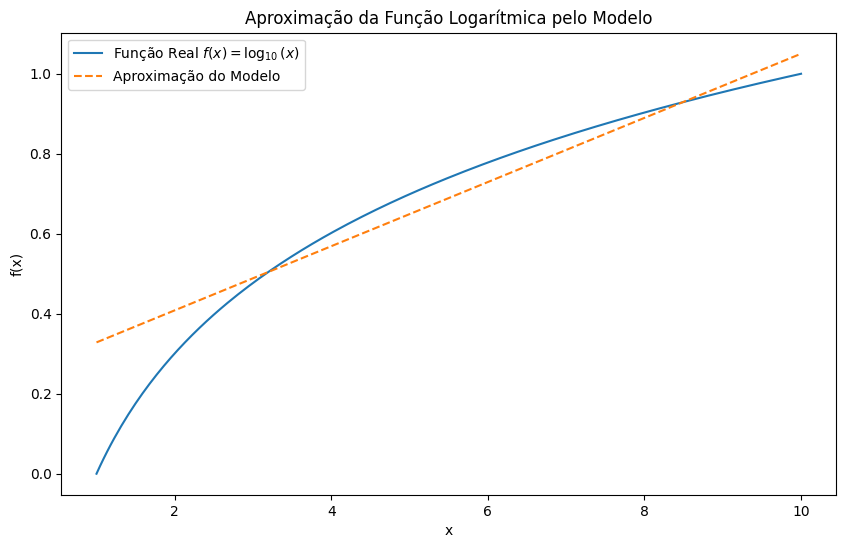

In [247]:
# Gerando dados de teste em um intervalo contínuo
x_test = np.linspace(1, 10, 200)
y_true = function_b(x_test)

# Propagação para frente para fazer previsões com o modelo treinado
x_test = x_test.reshape(1, -1)
AL_test, _ = L_model_forward(x_test, parameters_b, hidden_activation='relu', output_activation='linear')

# Plotando a função verdadeira e as previsões do modelo
plt.figure(figsize=(10, 6))
plt.plot(x_test.flatten(), y_true.flatten(), label='Função Real $f(x) = \log_{10}(x)$')
plt.plot(x_test.flatten(), AL_test.flatten(), label='Aproximação do Modelo', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Aproximação da Função Logarítmica pelo Modelo')
plt.legend()
plt.show()


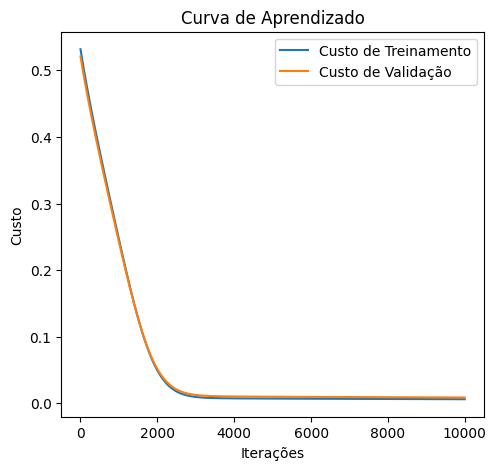

In [248]:
# Plotting the training and validation cost
plt.figure(figsize=(12, 5))

# Plot training cost
plt.subplot(1, 2, 1)
plt.plot(training_costs, label='Custo de Treinamento')
plt.plot(validation_costs, label='Custo de Validação')
plt.ylabel('Custo')
plt.xlabel('Iterações')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()

c) f(x) = 10x5+ 5x4+ 2x3– 0.5x2+ 3x + 2, onde 0 ≤ x ≤ 5


In [256]:
# Definindo a função complexa para aproximação
def function_c(x):
    return 10*x**5 + 5*x**4 + 2*x**3 - 0.5*x**2 + 3*x + 2

# Gerando dados de amostra (100 amostras uniformemente espaçadas entre 0 e 5)
x_samples_c = np.linspace(0, 5, 100)  # 100 amostras entre 0 e 5
y_samples_c = function_c(x_samples_c)

# Dividindo os dados em conjuntos de treinamento e validação
indices_c = np.random.permutation(len(x_samples_c))
train_indices_c = indices_c[:int(0.7*len(x_samples_c))]
val_indices_c = indices_c[int(0.7*len(x_samples_c)):]

x_train_c = x_samples_c[train_indices_c].reshape(1, -1)
y_train_c = y_samples_c[train_indices_c].reshape(1, -1)
x_val_c = x_samples_c[val_indices_c].reshape(1, -1)
y_val_c = y_samples_c[val_indices_c].reshape(1, -1)


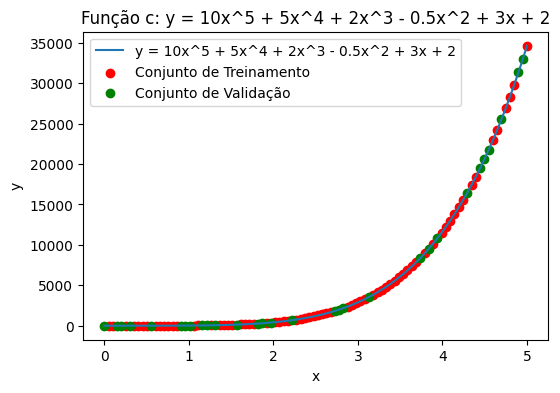

In [257]:
# Plotando a função c
plt.figure(figsize=(6, 4))
plt.plot(x_samples_c, y_samples_c, label='y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.scatter(x_train_c, y_train_c, color='r', label='Conjunto de Treinamento')
plt.scatter(x_val_c, y_val_c, color='g', label='Conjunto de Validação')
plt.title('Função c: y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [258]:
x_train_c.shape

(1, 70)

In [270]:
# Definindo a arquitetura da rede para a função c
layer_dims_c = [x_train_c.shape[0], 100, 100, 1]  # Exemplo: 1 neurônio na entrada, 20 e 10 na oculta, 1 na saída para a função c

# Inicializando os parâmetros para a função c
parameters_c = initialize_parameters_deep(layer_dims_c)

# Lista para armazenar os custos de treinamento e validação
training_costs_c = []
validation_costs_c = []

# Treinamento do modelo
for i in range(10000):
    # Forward propagation
    AL_c, caches_c = L_model_forward(x_train_c, parameters_c, hidden_activation='relu', output_activation='linear')
    
    # Compute cost.
    cost_train_c = compute_cost(AL_c, y_train_c)
    training_costs_c.append(cost_train_c)
    
    # Backward propagation.
    grads_c = L_model_backward(AL_c, y_train_c, caches_c, hidden_activation='relu', output_activation='linear', problema='regressao')
    
    # Update parameters.
    parameters_c = update_parameters(parameters_c, grads_c, learning_rate=0.01)
    
    # Compute validation cost.
    AL_val_c, _ = L_model_forward(x_val_c, parameters_c, hidden_activation='relu', output_activation='linear')
    cost_val_c = compute_cost(AL_val_c, y_val_c)
    validation_costs_c.append(cost_val_c)
    
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train_c} - Custo de Validação: {cost_val_c}")

Iteração 0 - Custo de Treinamento: 101007831.41081557 - Custo de Validação: 152228367.80874354
Iteração 1000 - Custo de Treinamento: 139786066.03435093 - Custo de Validação: 198324777.75659376
Iteração 2000 - Custo de Treinamento: 109160444.40125443 - Custo de Validação: 162189444.0180907
Iteração 3000 - Custo de Treinamento: 91867012.90258454 - Custo de Validação: 140752489.8515577
Iteração 4000 - Custo de Treinamento: 82101896.08040063 - Custo de Validação: 127871891.50951469
Iteração 5000 - Custo de Treinamento: 76587807.881177 - Custo de Validação: 120015643.20126912
Iteração 6000 - Custo de Treinamento: 73474156.58314596 - Custo de Validação: 115141395.19136517
Iteração 7000 - Custo de Treinamento: 71715964.82859708 - Custo de Validação: 112059876.7293751
Iteração 8000 - Custo de Treinamento: 70723163.14662375 - Custo de Validação: 110072478.05005373
Iteração 9000 - Custo de Treinamento: 70162555.81970453 - Custo de Validação: 108764378.23093368


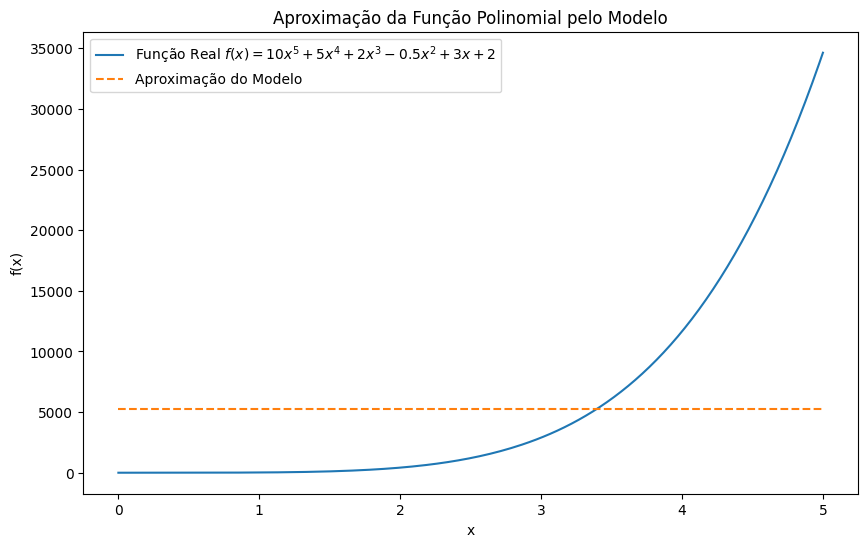

In [ ]:
# Gerando dados de teste em um intervalo contínuo
x_test_c = np.linspace(0, 5, 200)
y_true_c = function_c(x_test_c)

# Propagação para frente para fazer previsões com o modelo treinado
x_test_c = x_test_c.reshape(1, -1)
AL_test_c, _ = L_model_forward(x_test_c, parameters_c, hidden_activation='relu', output_activation='linear')

# Plotando a função verdadeira e as previsões do modelo
plt.figure(figsize=(10, 6))
plt.plot(x_test_c.flatten(), y_true_c.flatten(), label='Função Real $f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2$')
plt.plot(x_test_c.flatten(), AL_test_c.flatten(), label='Aproximação do Modelo', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Aproximação da Função Polinomial pelo Modelo')
plt.legend()
plt.show()
